In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import random
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader
import time
from sklearn.metrics import confusion_matrix, f1_score
import math
from tqdm import tqdm

In [9]:
N_ITER = 4
POPULATION_SIZE = 50
MUT_PROB = 0.9
RECOMB_PROB = 0.1

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
image_resize = 128
transform = transforms.Compose([
    transforms.Resize((image_resize, image_resize)), # Resize to 128 x 128 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [23]:
# loading the train data
batch_size = 1024

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

#loading the test data
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False )

Files already downloaded and verified
Files already downloaded and verified


### Dense (fully connected) layer

In [24]:
class Dense:
  def __init__(self, n_inputs, n_neurons):
    # He Weight Initialization
    self.weights = torch.randn(n_inputs, n_neurons) * torch.sqrt(torch.tensor(2. / n_inputs))
    self.biases = torch.zeros((1, n_neurons))
    self.weights = self.weights.to(device)
    self.biases = self.biases.to(device)
    self.prev_wchange = torch.zeros((n_inputs, n_neurons))
    self.prev_bchange = torch.zeros((1, n_neurons))
    self.prev_wchange = self.prev_wchange.to(device)
    self.prev_bchange = self.prev_bchange.to(device)

  
  def forward(self, inputs):
    self.inputs = inputs
    self.inputs = self.inputs.to(device)
    return torch.matmul(self.inputs, self.weights) + self.biases

  def backward(self, output_error):
    # calculating errors
    self.inputs_error = torch.matmul(output_error, self.weights.T)
    self.inputs_error = self.inputs_error.to(device)
    self.weights_grad = torch.matmul(self.inputs.T, output_error)
    self.weights_grad = self.weights_grad.to(device)
    self.biases_grad = torch.sum(output_error, axis=0, keepdims=True)
    self.biases_grad =  self.biases_grad.to(device)
    return self.inputs_error


### Activation Layers


In [25]:
class ReLU:
  def forward(self, inputs):
    self.inputs = inputs.clone()
    self.inputs = self.inputs.to(device)
    return torch.maximum(torch.zeros_like(inputs), inputs)

  def backward(self, output_error):
    self.inputs_error = output_error.clone()
    self.inputs_error = self.inputs_error.to(device)
    self.inputs_error[self.inputs <= 0] = 0
    return self.inputs_error

In [26]:
class Softmax:
  def forward(self, inputs):
    self.inputs = inputs.clone()
    self.inputs = self.inputs.to(device)
    exp_inputs = torch.exp(self.inputs - torch.max(self.inputs, dim=1, keepdim=True).values)
    exp_inputs = exp_inputs.to(device)
    self.outputs = exp_inputs / torch.sum(exp_inputs, dim=1, keepdim=True)
    self.outputs = self.outputs.to(device)
    return self.outputs

In [27]:
feature_extractor = resnet34(weights="DEFAULT")
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
  param.requires_grad = False

feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

In [28]:
def calculate_k(population_size, curr_iter):
  return max(2, population_size * curr_iter // N_ITER)

In [29]:
class Model:
  def __init__(self):
    self.Layer1 = Dense(num_features, 20)
    self.Act1 = ReLU()
    self.Layer2 = Dense(20, 10)
    self.Act2 = Softmax()
    self.y_predtr = torch.zeros(0, dtype=torch.long, device = device)
    self.y_true_train = torch.zeros(0, dtype=torch.long, device = device)
    self.y_predts = torch.zeros(0, dtype=torch.long, device = device)
    self.y_true_test = torch.zeros(0, dtype=torch.long, device = device)
        
  def get_train_accuracy(self, iter):
    train_accuracy = 0
    for x_train, y_train in tqdm(train_dataloader, desc=f"Training", colour="blue"):
      # Forward pass
      x_train, y_train = x_train.to(device), y_train.to(device)
      x = feature_extractor(x_train)
      x = self.Layer1.forward(x)
      x = self.Act1.forward(x)
      x = self.Layer2.forward(x)
      x = self.Act2.forward(x)
        
      y_predict_train = torch.argmax(x, dim=1)
      accuracy = torch.mean((y_train == y_predict_train).float())
      train_accuracy += accuracy.item()
      if iter == N_ITER:
        self.y_predtr = torch.cat([self.y_predtr, y_predict_train.view(-1)])
        self.y_true_train = torch.cat([self.y_true_train, y_train.view(-1)])
        
    train_accuracy /= len(train_dataloader)
    return train_accuracy

  def get_test_accuracy(self, iter):
    test_accuracy = 0
    with torch.no_grad():
      for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
        # Forward pass
        x_test, y_test = x_test.to(device), y_test.to(device)
        x = feature_extractor(x_test)
        x = self.Layer1.forward(x)
        x = self.Act1.forward(x)
        x = self.Layer2.forward(x)
        x = self.Act2.forward(x)

        # Report batch metrics
        y_predict_test = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_test == y_predict_test).float())
        test_accuracy += accuracy.item()
        if iter == N_ITER:
          self.y_predts = torch.cat([self.y_predts,y_predict_test.view(-1)])
          self.y_true_test=torch.cat([self.y_true_test, y_test.view(-1)])

    test_accuracy /= len(test_dataloader)
    return test_accuracy

In [30]:
class Chromosome:
  def __init__(self, mut_prob, recomb_prob, id, calc_fitness):
    self.model = None
    self.id = id
    self.current_iter = 0
    self.mut_prob = mut_prob
    self.recomb_prob = recomb_prob
    self.train_fitness = 0
    self.test_fitness = 0
    self.calc_fitness = calc_fitness
    self.init_chromosome()
      
  def init_chromosome(self):
    self.model = Model()
    if self.calc_fitness:
      self.calculate_fitness()
      
  def mutation(self):
    for i in range(len(self.model.Layer1.weights)):
      prob = random.uniform(0, 1)
      if prob <= self.mut_prob:
        for j in range(len(self.model.Layer1.weights[i])):
          r = random.gauss(0, 0.5)
          new_w = self.model.Layer1.weights[i, j] + r
          self.model.Layer1.weights[i, j] = max(min(1.5, new_w), -1.5)
            
    for i in range(len(self.model.Layer2.weights)):
      prob = random.uniform(0, 1)
      if prob <= self.mut_prob:
        for j in range(len(self.model.Layer2.weights[i])):
          r = random.gauss(0, 0.5)
          new_w = self.model.Layer2.weights[i, j] + r
          self.model.Layer2.weights[i, j] = max(min(1.5, new_w), -1.5)
        
    for i in range(len(self.model.Layer1.biases)):
      prob = random.uniform(0, 1)
      if prob <= self.mut_prob:
        for j in range(len(self.model.Layer1.biases[i])):
          r = random.gauss(0, 0.5)
          new_b = self.model.Layer1.biases[i, j] + r
          self.model.Layer1.biases[i, j] = max(min(1.5, new_b), -1.5)
            
    for i in range(len(self.model.Layer2.biases)):
      prob = random.uniform(0, 1)
      if prob <= self.mut_prob:
        for j in range(len(self.model.Layer2.biases[i])):
          r = random.gauss(0, 0.5)
          new_b = self.model.Layer2.biases[i, j] + r
          self.model.Layer2.biases[i, j] = max(min(1.5, new_b), -1.5)
        
    self.calculate_fitness()

  def calculate_fitness(self):
    print(f"Chromosome: {self.id}")
    self.train_fitness = self.model.get_train_accuracy(self.current_iter)
    self.test_fitness = self.model.get_test_accuracy(self.current_iter)

In [31]:
class EvolutionaryAlgorithm:
  def __init__(self, n_iter, mut_prob, recomb_prob, population_size):
    self.n_iter = n_iter
    self.mut_prob = mut_prob
    self.recomb_prob = recomb_prob
    self.population = []
    self.population_size = population_size
    self.current_iter = 0
    self.train_fitness_avg = 0
    self.test_fitness_avg = 0
    self.train_acc = {'128':[]}
    self.test_acc = {'128':[]}

  # Random initialization
  def init_population(self):
    for id in range(self.population_size):
      young_pop = Chromosome(self.mut_prob, self.recomb_prob, id + 1, True)
      self.population.append(young_pop)

  # Fitness Tournament selection
  def tournament_selection(self, tour_pop, k):
    parents = random.sample(tour_pop, k=k)
    parents = sorted(parents, key=lambda agent: agent.train_fitness, reverse=True)
    bestparent = parents[0]
    
    return bestparent

  def parent_selection(self):
    parents = []
    for _ in range(self.population_size):
      best_parent = self.tournament_selection(self.population, calculate_k(len(self.population), self.current_iter))
      parents.append(best_parent)

    return parents
  
  def crossover(self, nn1_weights, nn2_weights):
    child_weights = torch.empty((nn1_weights.shape[0], nn1_weights.shape[1]))
    for i in range(len(nn1_weights)):
      split = random.randint(0, nn1_weights[i].shape[0]-1)
      child_weights[i] = torch.cat((nn1_weights[i][:split], nn2_weights[i][split:]), 0)
        
    return child_weights

#     # One-point crossover
#     def recombination(self, mating_pool):
#         youngs = []
#         for _ in range(self.population_size // 2):
#             parents = random.choices(mating_pool, k=2)
#             young_1 = Chromosome(self.mut_prob, self.recomb_prob)
#             young_2 = Chromosome(self.mut_prob, self.recomb_prob)
#             prob = random.uniform(0, 1)
#             if prob <= self.recomb_prob:
#                 young_1.model.Layer1.weights = self.crossover(parents[0].model.Layer1.weights.detach().clone(), parents[1].model.Layer1.weights.detach().clone())
#                 young_2.model.Layer1.weights = self.crossover(parents[1].model.Layer1.weights.detach().clone(), parents[0].model.Layer1.weights.detach().clone())
#                 young_1.model.Layer2.weights = self.crossover(parents[0].model.Layer2.weights.detach().clone(), parents[1].model.Layer2.weights.detach().clone())
#                 young_2.model.Layer2.weights = self.crossover(parents[1].model.Layer2.weights.detach().clone(), parents[0].model.Layer2.weights.detach().clone())
#             else:
#                 young_1.model.Layer1.weights = parents[0].model.Layer1.weights.detach().clone()
#                 young_2.model.Layer1.weights = parents[1].model.Layer1.weights.detach().clone()
#                 young_1.model.Layer2.weights = parents[0].model.Layer2.weights.detach().clone()
#                 young_2.model.Layer2.weights = parents[1].model.Layer2.weights.detach().clone()

#             youngs.append(young_1)
#             youngs.append(young_2)
          
#         return youngs
  
  # Whole crossover
  def recombination(self, mating_pool):
    youngs = []
    for _ in range(self.population_size):
      parents = random.choices(mating_pool, k=2)
      young = Chromosome(self.mut_prob, self.recomb_prob, 0, False)
      prob = random.uniform(0, 1)
      alpha = random.uniform(0, 1)
      young.model.Layer1.weights = ((alpha * parents[0].model.Layer1.weights.detach().clone()) 
                                  + ((1 - alpha) * parents[1].model.Layer1.weights.detach().clone()))

      young.model.Layer2.weights = ((alpha * parents[0].model.Layer2.weights.detach().clone()) 
                                  + ((1 - alpha) * parents[1].model.Layer2.weights.detach().clone()))

      young.model.Layer1.biases = ((alpha * parents[0].model.Layer1.biases.detach().clone()) 
                                  + ((1 - alpha) * parents[1].model.Layer1.biases.detach().clone()))

      young.model.Layer2.biases = ((alpha * parents[0].model.Layer2.biases.detach().clone()) 
                                  + ((1 - alpha) * parents[1].model.Layer2.biases.detach().clone()))

      youngs.append(young)
        
    return youngs


  def survival_selection(self, youngs):
    mpl = self.population.copy() + youngs
    mpl = sorted(mpl, key=lambda agent: agent.train_fitness, reverse=True)
    mpl = mpl[:self.population_size].copy()
    
    return mpl

  def mutation(self, youngs):
    for young in youngs:
      young.current_iter = self.current_iter + 1
      young.mutation()
        
    return youngs
      
  def calculate_train_fitness_avg(self):
    self.train_fitness_avg = 0
    for pop in self.population:
      self.train_fitness_avg += pop.train_fitness
        
    self.train_fitness_avg /= self.population_size

  def calculate_test_fitness_avg(self):
    self.test_fitness_avg = 0
    for pop in self.population:
      self.test_fitness_avg += pop.test_fitness
        
    self.test_fitness_avg /= self.population_size

  def set_id(self, youngs):
    for id, young in enumerate(youngs):
      young.id  = id + 1

    return youngs

  def run(self):
    print("------------------------------------Initialization------------------------------------")
    self.init_population()
    print("------------------------------------Training------------------------------------")
    for _ in range(self.n_iter):
      parents = self.parent_selection().copy()
      youngs = self.recombination(parents).copy()
      youngs = self.set_id(youngs).copy()
      youngs = self.mutation(youngs).copy()
      self.population = self.survival_selection(youngs).copy()
      self.calculate_train_fitness_avg()
      self.calculate_test_fitness_avg()
      self.current_iter += 1
      best_current = sorted(self.population, key=lambda agent: agent.train_fitness, reverse=True)[0]
      print(f"current iteration: {self.current_iter} / {self.n_iter}",
            f", best train fitness: {best_current.train_fitness}, average train fitness: {self.train_fitness_avg}, average test fitness: {self.test_fitness_avg}")
      print("-------------------------------------------------------------------------------------------------")
      self.train_acc['128'].append(self.train_fitness_avg)
      self.test_acc['128'].append(self.test_fitness_avg)

    ans = sorted(self.population, key=lambda agent: agent.train_fitness, reverse=True)[0]
    
    return ans, self.train_acc, self.test_acc

In [32]:
ea = EvolutionaryAlgorithm(N_ITER, MUT_PROB, RECOMB_PROB, POPULATION_SIZE)
ans, train_acc, test_acc = ea.run()

------------------------------------Initialization------------------------------------
Chromosome: 1


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


Chromosome: 2


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Chromosome: 3


Testing: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Chromosome: 4


Testing: 100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


------------------------------------Training------------------------------------
Chromosome: 1


Training:  10%|█         | 5/49 [00:05<00:51,  1.18s/it]


KeyboardInterrupt: 

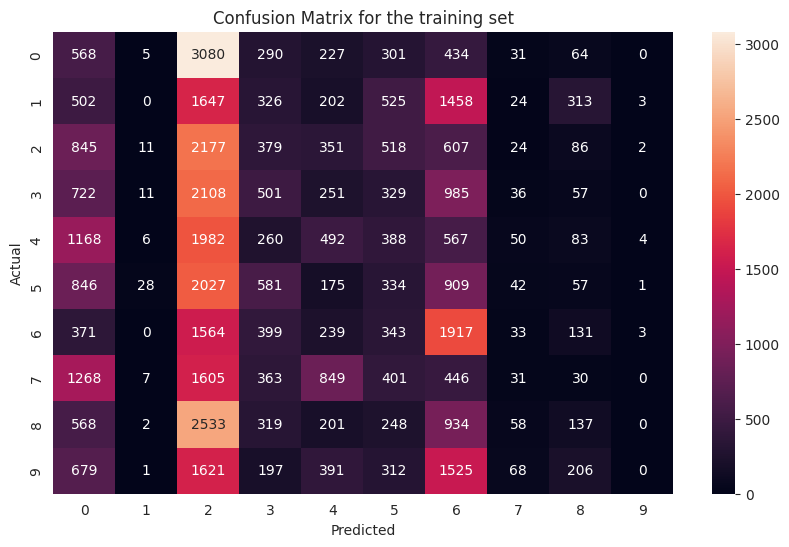

In [119]:
#Confusion Matrix for the training set
y_predtr_numpy = ans.model.y_predtr.data.cpu().numpy()
y_train_numpy = ans.model.y_true_train.data.cpu().numpy()
cm_train = confusion_matrix(y_train_numpy, y_predtr_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the training set")
plt.show()

In [120]:
print(f1_score(y_train_numpy, y_predtr_numpy, average='weighted'))

0.08882665617818046


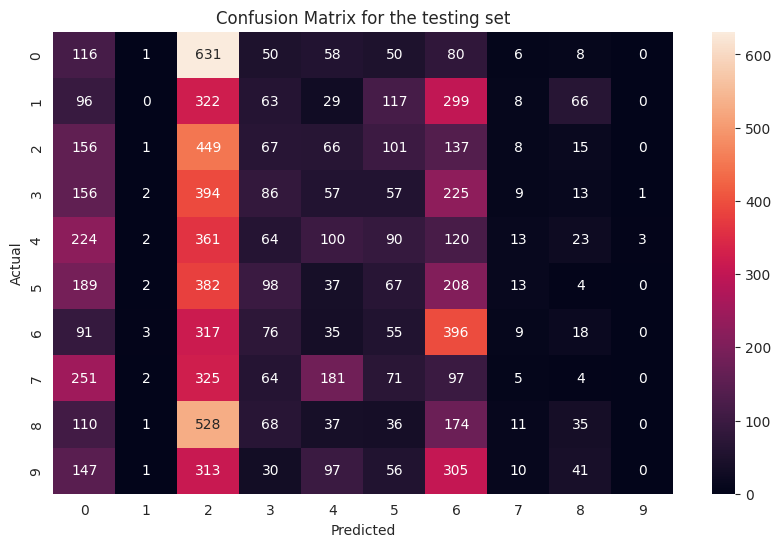

In [121]:
#Confusion Matrix for the test set
y_predts_numpy = ans.model.y_predts.data.cpu().numpy()
y_test_numpy = ans.model.y_true_test.data.cpu().numpy()
cm_train = confusion_matrix(y_test_numpy, y_predts_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the testing set")
plt.show()

In [122]:
print(f1_score(y_test_numpy, y_predts_numpy, average='weighted'))

0.08968636043332683


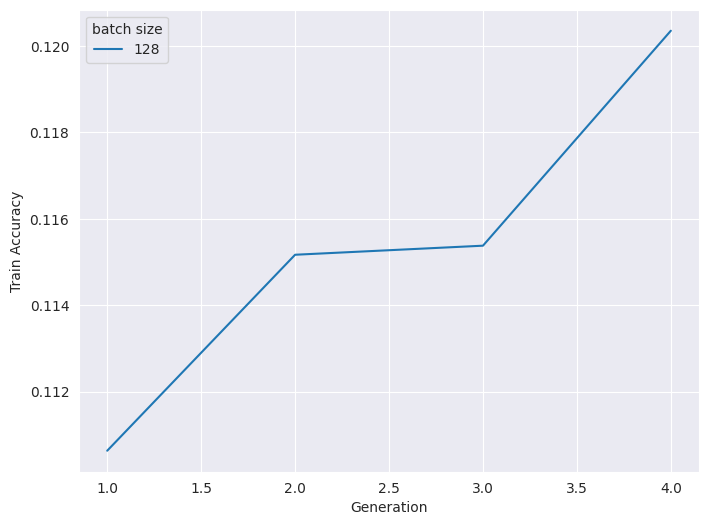

In [123]:
# train acc 
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in train_acc.items():
    sb.lineplot(x=range(1, N_ITER + 1), y=data, label=key)

# Add labels and legend
plt.ylabel('Train Accuracy')
plt.xlabel('Generation')
plt.legend(title = 'batch size')

# Show the plot
plt.show()

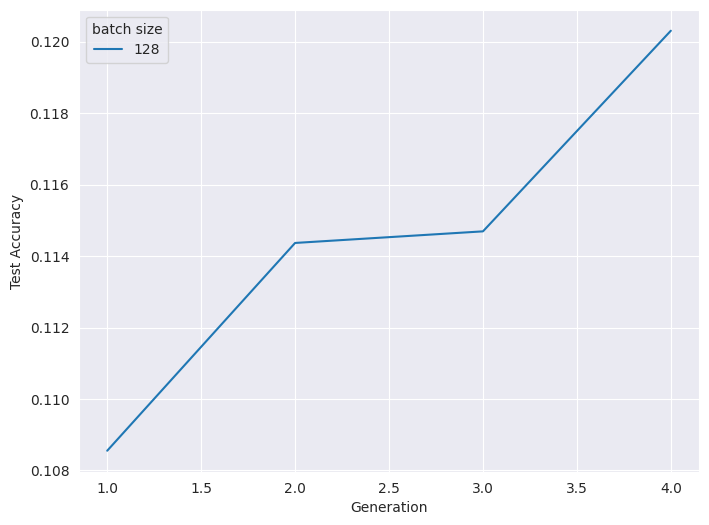

In [124]:
# test acc 
sb.set_style("darkgrid")
plt.figure(figsize=(8, 6))

# Loop through each key in the dictionary and plot a line
for key, data in test_acc.items():
    sb.lineplot(x=range(1, N_ITER + 1), y=data, label=key)

# Add labels and legend
plt.ylabel('Test Accuracy')
plt.xlabel('Generation')
plt.legend(title = 'batch size')

# Show the plot
plt.show()